# TRANSFORMER ARCHITECTURE FOR INLINED FUNCTION INSTRUCTION IDENTIFICATION

##Step 0: mount Drive and import libraries

In [1]:
from google.colab import drive
import os

#Palmtree imports
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
from torch.autograd import Variable
import torch
import numpy as np

#Data preprocessing imports
from pickle import load

#Model training imports
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

#Model testing imports
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

drive.mount('/content/gdrive')

<ipython-input-1-3607b4ce17e8>:6: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Mounted at /content/gdrive


## Step 1: load Palmtree embedding

Install  bert-pytorch

In [2]:
!pip install bert-pytorch

Import modules and load [pre-trained PalmTree model](https://github.com/palmtreemodel/PalmTree/tree/master/pre-trained_model)

In [3]:
os.chdir("/content/gdrive/MyDrive/Tesi/Palmtree")
from config import *
import eval_utils as utils

palmtree = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")


Loading Vocab ./palmtree/vocab
Vocab Size:  6631


Copy the how2use code to test correct import and functioning embedding

**NOTE:** might require GPU environment


In [4]:
text = ["mov rbo rdi",
        "mov ebx 0x1",
        "mov rdx rbx",
        "call memcpy",
        "mov [ rcx + rbx ] 0x0",
        "mov rcx rax",
        "mov [ rax ] 0x2e"]

# it is better to make batches as large as possible.
embeddings = palmtree.encode(text)
print("usable embedding of this basicblock:", embeddings)
print("the shape of output tensor: ", embeddings.shape)

usable embedding of this basicblock: [[ 2.38421893e+00  1.58078265e+00  4.70259756e-01  2.52216011e-01
  -1.39860582e+00 -1.04384534e-01 -1.10426629e+00 -1.68176115e+00
  -1.17237246e+00 -1.37533319e+00  5.52811138e-02  3.41558576e+00
  -1.93328857e+00 -9.05740857e-01  1.92183721e+00  1.09623921e+00
   2.85070395e+00 -4.09158278e+00  1.91642272e+00 -2.82078171e+00
   2.21341968e+00 -1.94647503e+00  1.33180404e+00  4.04114914e+00
   1.64850616e+00 -4.89377737e+00 -8.58392656e-01  3.81815314e-01
   1.22160578e+00  8.96680772e-01  1.39022970e+00 -9.57940876e-01
   2.20012975e+00 -3.97315502e-01  1.30700815e+00  2.28564811e+00
  -1.20861506e+00  1.11897182e+00 -1.15110576e+00  3.31326675e+00
   3.54582453e+00  1.17317832e+00  2.26531267e+00 -2.55426836e+00
  -1.19632065e+00 -1.69074559e+00 -1.89549878e-01  8.66954505e-01
   3.60986185e+00 -8.24573815e-01  2.46334076e-01 -8.00894547e+00
   1.17532957e+00  1.64168831e-02  2.99125409e+00  2.44515300e+00
   1.55092001e+00 -2.10120177e+00 -1.78

## Step 2: Data preprocessing


### 2.1: Load pickled dataset

Unpickle the snippet list object - all original dependencies are necessary

In [5]:
os.chdir("/content/gdrive/MyDrive/Tesi/deinliner")

In [6]:
!pip install pyelftools angr
from extract_dataset import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [7]:
with open("data/pickled_data.pickle", "rb") as pickled_dataset:
  snippet_list = load(pickled_dataset)

Quick test

In [8]:
snippet = snippet_list[49]
print(len(snippet.input_seq))
print(len(snippet.target_seq))
for i in range(len(snippet.input_seq)):
  print("{}, {}\n".format(str(snippet.instructions[i]), snippet.target_seq[i]))



29
29
0x40b85a: mov rdx, qword ptr [rbp + 0x40] [INL], True

0x40b85e: mov rcx, qword ptr [rbp + 0x38] [INL], True

0x40b862: mov rax, rdx [INL], True

0x40b865: sub rax, rcx [INL], True

0x40b868: sar rax, 2 [INL], True

0x40b86c: mov qword ptr [rbp + 0x50], 0, False

0x40b874: lea r12, [rbp + 0x50], False

0x40b878: lea r13, [rbp + 0x68], False

0x40b87c: lea rsi, [rip + 0x8ed5], False

0x40b883: mov qword ptr [rbp + 0x58], 0, False

0x40b88b: mov qword ptr [rbp], rsi, False

0x40b88f: movsxd rsi, dword ptr [rbp + 0x10], False

0x40b893: mov qword ptr [rbp + 0x60], 0, False

0x40b89b: mov qword ptr [rbp + 0x68], 0, False

0x40b8a3: mov qword ptr [rbp + 0x70], 0, False

0x40b8ab: mov qword ptr [rbp + 0x78], 0, False

0x40b8b3: mov qword ptr [rbp + 0x80], 0, False

0x40b8be: mov qword ptr [rbp + 0x88], 0, False

0x40b8c9: mov qword ptr [rbp + 0x90], 0, False

0x40b8d4: cmp rsi, rax [INL], True

0x40b8d7: ja 0x40ba60 [INL], True

0x40b8dd: jae 0x40b8ec [INL], True

0x40b8df: lea rax, [r

### 2.2: Split the dataset

Perform the train/validation/test split directly on snippets, in order to maintain class distribution and keep more information on test dataset for more precise testing

In [9]:
def percentage_split(data, percentage):
  split_size = round(len(data) * (1-percentage) - 0.5)
  return data[:split_size], data[split_size:]

def split_by_methods(snippet_list, test_perc, val_perc):
  methods_dict = {method : [] for method in METHODS}
  for snippet in snippet_list:
    methods_dict[snippet.method].append(snippet)

  train, val, test= [], [], []
  for key in methods_dict:
    method_train, method_test = percentage_split(methods_dict[key], test_perc)
    method_train, method_val = percentage_split(method_train, val_perc)
    train += method_train
    val += method_val
    test += method_test
  return train, val, test

In [10]:
test_perc = 0.2
val_perc = 0.2
train_snippets, val_snippets, test_snippets = split_by_methods(snippet_list, test_perc, val_perc)

print(len(train_snippets), len(val_snippets), len(test_snippets))

19137 4788 5989


### 2.3 Encode dataset

Create a dictionary for bidirectional encoding of methods - represented via one-hot encoding

In [11]:
method_list = list(METHODS)
num_label_list = [method_list.index(elem) for elem in method_list]
one_hot = tfk.utils.to_categorical(num_label_list)
label_encoding = {method : one_hot[method_list.index(method)] for method in method_list }


For each snippet in training data:
- Produce its embedding via Palmtree, and split sequences according to window length
- Encode its method label as one-hot
- Encode its target sequence as a binary sequence

All in the form of numpy arrays to feed into the model

Note: encoding is quite slow!

In [12]:
def segment2D(vector, window_len):
  if (len(vector) % window_len > 0):
    num_windows = (len(vector)//window_len)+1
    ceiling = num_windows * window_len
    print("Size {} will be extended to {}".format(len(vector), ceiling))
    vector = np.pad(vector, ((0, ceiling-len(vector)), (0,0)))
  else:
    num_windows = len(vector)//window_len
  segments = np.split(vector, num_windows)
  return segments

def segment1D(vector, window_len):
  if (len(vector) % window_len > 0):
    num_windows = (len(vector)//window_len)+1
    ceiling = num_windows * window_len
    print("Size {} will be extended to {}".format(len(vector), ceiling))
    vector = np.pad(vector, (0, ceiling-len(vector)))
  else:
    num_windows = len(vector)//window_len
  segments = np.split(vector, num_windows)
  return segments


def encode_snippet(snippet, window_len):
  embedding = palmtree.encode(snippet.input_seq)
  embedded_seq_list = segment2D(embedding, window_len)
  encoded_method_list = [label_encoding[snippet.method] for i in range(len(embedded_seq_list))]
  encoded_target = np.array([1 if inl else 0 for inl in snippet.target_seq])
  encoded_target_list = segment1D(encoded_target, window_len)
  return embedded_seq_list, encoded_method_list, encoded_target_list

def encode_snippet_list(snippet_list, window_len):
  input_embedding_list = []
  input_label_list = []
  target_list = []
  for snippet in snippet_list:
    input_seqs, input_labels, target_seqs = encode_snippet(snippet, window_len)
    input_embedding_list += (input_seqs)
    input_label_list += (input_labels)
    target_list +=(target_seqs)

  input_embedding = np.stack(input_embedding_list)
  input_label = np.stack(input_label_list)
  target = np.stack(target_list)
  return input_embedding, input_label, target



#### Option A: extract and encode data from scratch

In [ ]:
window_len = 20
x1_train, x2_train, y_train  = encode_snippet_list(train_snippets, window_len)
x1_val, x2_val, y_val = encode_snippet_list(val_snippets, window_len)

print(x1_train.shape, x2_train.shape, y_train.shape)
print(x1_val.shape, x2_val.shape, y_val.shape)

Output streaming troncato alle ultime 5000 righe.
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 5 will be extended to 20
Size 5 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 3 will be extended to 20
Size 48 will be extended to 60
Size 48 will be ext

In [ ]:
with open("data/train.npz", "wb") as train_data_backup:
  np.savez(train_data_backup, x1_train=x1_train, x2_train=x2_train, y_train=y_train)
with open("data/val.npz", "wb") as val_data_backup:
  np.savez(val_data_backup, x1_val=x1_val, x2_val=x2_val, y_val=y_val)


#### Option B: load already encoded data

In [13]:
with open("data/train.npz", "rb") as train_data_backup:
  test_data = np.load(train_data_backup)
  x1_train = test_data['x1_train']
  x2_train = test_data['x2_train']
  y_train = test_data['y_train']

with open("data/val.npz", "rb") as val_data_backup:
  test_data = np.load(val_data_backup)
  x1_val = test_data['x1_val']
  x2_val = test_data['x2_val']
  y_val = test_data['y_val']

print(x1_train.shape, x2_train.shape, y_train.shape)
print(x1_val.shape, x2_val.shape, y_val.shape)

(31192, 20, 128) (31192, 12) (31192, 20)
(8221, 20, 128) (8221, 12) (8221, 20)


## Step 3: build the model and train it

#### Option A: redesign and train new model

Perform the train/test/validation split

In [ ]:
def build_LSTM(input_shape):
  input_layer = tfkl.Input(shape=input_shape, name='Input')
  masking = tfkl.Masking(mask_value=0)(input_layer)
  first_lstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, input_shape=input_shape))(masking)
  second_lstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, input_shape=input_shape))(first_lstm)
  third_lstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, input_shape=input_shape))(second_lstm)
  dense_layer = tfkl.Dense(32, activation='leaky_relu')(second_lstm)
  output_dense = tfkl.Dense(1, activation='sigmoid')(dense_layer)
  output_layer = tfkl.Flatten()(output_dense)

  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
  model.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.Adam(1e-2), metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])
  return model

print(x1_train.shape[1:])
decoder = build_LSTM(x1_train.shape[1:])

(20, 128)


Print summary

In [ ]:
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20, 128)]         0         
                                                                 
 masking_1 (Masking)         (None, 20, 128)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 20, 64)            41216     
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 20, 64)            24832     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 20, 64)            24832     
 onal)                                                           
                                                             

In [ ]:
batch_size = 256
epochs = 200

history = decoder.fit(
    x = x1_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x1_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=5, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
122/122 [==============================] - 70s 179ms/step - loss: 0.2741 - binary_accuracy: 0.8968 - val_loss: 0.1304 - val_binary_accuracy: 0.9522 - lr: 0.0100
Epoch 2/200
122/122 [==============================] - 8s 64ms/step - loss: 0.1071 - binary_accuracy: 0.9595 - val_loss: 0.0996 - val_binary_accuracy: 0.9647 - lr: 0.0100
Epoch 3/200
122/122 [==============================] - 10s 81ms/step - loss: 0.0798 - binary_accuracy: 0.9695 - val_loss: 0.0913 - val_binary_accuracy: 0.9685 - lr: 0.0100
Epoch 4/200
122/122 [==============================] - 7s 60ms/step - loss: 0.0642 - binary_accuracy: 0.9755 - val_loss: 0.0843 - val_binary_accuracy: 0.9711 - lr: 0.0100
Epoch 5/200
122/122 [==============================] - 11s 86ms/step - loss: 0.0561 - binary_accuracy: 0.9786 - val_loss: 0.0835 - val_binary_accuracy: 0.9700 - lr: 0.0100
Epoch 6/200
122/122 [==============================] - 7s 56ms/step - loss: 0.0488 - binary_accuracy: 0.9814 - val_loss: 0.0805 - val_binary_

Optionally, save the model

In [ ]:
model_name = "32BiLSTMx3+32CNN"
decoder.save("models/{}".format(model_name))

KeyboardInterrupt: ignored

#### Option B: load previously saved model

In [14]:
model_name = "32BiLSTMx3+32CNN"
decoder = tfk.saving.load_model("models/{}".format(model_name))

## Step 4: evaluate on test data

*NOTE: this whole section is somewhat messy and might need refactoring in the future*

### 4.1 Preprocess and evaluate test data without losing information


Create a fitting object for test data.

Since it needs to be evaluated in different ways, sorted and analyzed, it is important to retain as much information as possible

In [15]:
class TestSample:
  def __init__(self, snippet, y_true, y_pred):
    self.snippet = snippet
    self.y_true = y_true
    self.y_pred = y_pred

  def count_errors(self):
    round_pred = np.round(self.y_pred)
    return np.count_nonzero(self.y_true != round_pred)

  def get_misclassified_instructions(self):
    fp, fn = [], []
    round_pred = np.round(self.y_pred)
    for i in range(len(self.y_true)):
      if self.y_true[i] > round_pred[i]:
        fn.append(self.snippet.instructions[i])
      elif self.y_true[i] < round_pred[i]:
        fp.append(self.snippet.instructions[i])
      else:
        pass
    return fp, fn


Encode all test data

Note: can be reapplied only when encoding changes

In [16]:
snippet_encoding_map = dict()
test_samples = []
window_len = 20

for snippet in test_snippets:
  input_seqs, input_labels, target_seqs = encode_snippet(snippet, window_len)
  input_seqs = np.stack(input_seqs)
  snippet_encoding_map[snippet] = (input_seqs, target_seqs)

Output streaming troncato alle ultime 5000 righe.
Size 48 will be extended to 60
Size 48 will be extended to 60
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 47 will be extended to 60
Size 47 will be extended to 60
Size 42 will be extended to 60
Size 42 will be extended to 60
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 34 will be extended to 40
Size 52 will be extended to 60
Size 52 will be extended to 60
Size 19 will be extended to 20
Size 19 will be extended to 20
Size 39 will be extended to 40
Size 39 will be extended to 40
Size 48 will be extended to 60
Size 48 will be extended to 60
Size 38 will be exte

Evaluate all test data:

Note: Can be redone only when model is retrained

In [17]:
for snippet in test_snippets:
  padded_true = np.concatenate(snippet_encoding_map[snippet][1])
  y_true = np.resize(padded_true, len(snippet.target_seq))
  stacked_pred = decoder.predict(snippet_encoding_map[snippet][0])
  padded_pred = np.concatenate([array for array in stacked_pred])
  y_pred = np.resize(padded_pred, len(snippet.target_seq))
  print(len(snippet.target_seq), y_true.size, y_pred.size)
  test_samples.append(TestSample(snippet, y_true, y_pred))

print(len(test_samples))

Output streaming troncato alle ultime 5000 righe.
12 12 12
1/1 [==============================] - 0s 58ms/step
8 8 8
1/1 [==============================] - 0s 59ms/step
5 5 5
1/1 [==============================] - 0s 43ms/step
16 16 16
1/1 [==============================] - 0s 49ms/step
5 5 5
1/1 [==============================] - 0s 53ms/step
14 14 14
1/1 [==============================] - 0s 64ms/step
7 7 7
1/1 [==============================] - 0s 53ms/step
5 5 5
1/1 [==============================] - 0s 51ms/step
6 6 6
1/1 [==============================] - 0s 43ms/step
5 5 5
1/1 [==============================] - 0s 40ms/step
12 12 12
1/1 [==============================] - 0s 52ms/step
8 8 8
1/1 [==============================] - 0s 56ms/step
5 5 5
1/1 [==============================] - 0s 53ms/step
16 16 16
1/1 [==============================] - 0s 43ms/step
5 5 5
1/1 [==============================] - 0s 42ms/step
13 13 13
1/1 [==============================] - 0s 25ms/step
14 1

### 4.2 Evaluate whole dataset

Setup directories to save data into

In [18]:
report_dir = os.path.join("testing_reports", model_name)

Evaluate whole dataset

Particularly useful in the context of trying if a new model improved the previous in general

In [19]:
def make_classification_report(test_samples, label, report_dir):
  report_name = "{}_report.txt".format(label)
  report_path = os.path.join(report_dir, report_name)
  with open(report_path, "w") as report:
    header = "{}_report".format(label)
    print(header, file=report)
    bulk_y_true = np.concatenate([sample.y_true for sample in test_samples])
    bulk_y_pred = np.concatenate([np.round(sample.y_pred) for sample in test_samples])
    print(metrics.classification_report(bulk_y_true, bulk_y_pred, digits=4), file=report)

    seq_accuracy = [1 - sample.count_errors()/len(sample.y_true) for sample in test_samples]
    avg_accuracy = sum(seq_accuracy)/len(seq_accuracy)
    accuracy_text = "Model predicts sequences with an accuracy of {:0.2%}".format(avg_accuracy)
    print(accuracy_text, file=report)
  return report_path

def make_confusion_matrix(test_samples, label, report_dir):
  matrix_name = "{}_matrix.png".format(label)
  matrix_path = os.path.join(report_dir, matrix_name)

  bulk_y_true = np.concatenate([sample.y_true for sample in test_samples])
  bulk_y_pred = np.concatenate([np.round(sample.y_pred) for sample in test_samples])
  cm = np.array(metrics.confusion_matrix(bulk_y_true, bulk_y_pred))

  fig, ax = plt.subplots(figsize=(10, 5))
  cm_labels = ["True Negative","False Positive","False Negative","True Positive"]
  cm_counts = [f"{value:g}" for value in cm.flatten()]
  cm_percs = [f"{value:.2%}" for value in cm.flatten()/np.sum(cm)]
  annotations = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_labels, cm_counts, cm_percs)]
  annotations = np.asarray(annotations).reshape(2,2)
  sns.heatmap(cm, fmt='', annot=annotations, ax=ax, xticklabels=["Not Inlined", "Inlined"], yticklabels=["Not Inlined", "Inlined"], square=True, cbar=True) # Missing axis, labels on numbers
  ax.set_ylabel("Correct", fontsize=12)
  ax.set_xlabel("Predicted", fontsize=12)
  ax.set_title("Confusion matrix of class {}".format(label), fontsize = 15)

  plt.savefig(matrix_path)
  plt.show
  return matrix_path


general_report
              precision    recall  f1-score   support

           0     0.9274    0.9100    0.9186     25714
           1     0.9785    0.9829    0.9807    107071

    accuracy                         0.9688    132785
   macro avg     0.9529    0.9465    0.9497    132785
weighted avg     0.9686    0.9688    0.9687    132785

Model predicts sequences with an accuracy of 97.53%



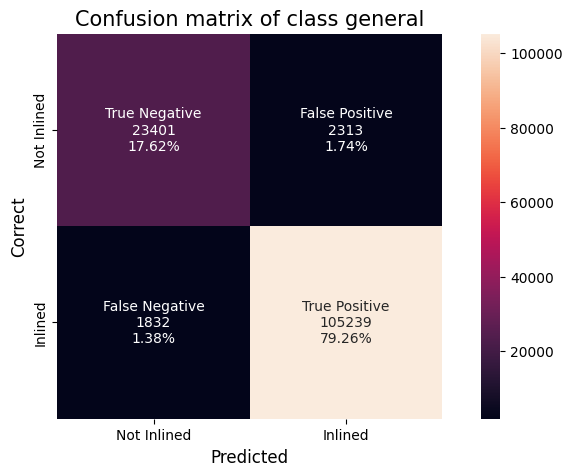

In [20]:
#What if smaller methods are filtered out?
#big_test_samples = list(filter(lambda x: len(x.y_pred) > 20, test_samples))
#len(big_test_samples)
label = "general"
report_path = make_classification_report(test_samples, label, report_dir)
matrix_path = make_confusion_matrix(test_samples, label, report_dir)

with open(report_path, "r") as report:
  print(''.join(report.readlines()))


### 4.3 Evaluate by method and optimization

Cross-compare statistics regarding optimizations and methods

In [23]:
label_report_dir = os.path.join(report_dir, "label related stats")
if not os.path.exists(label_report_dir):
  os.mkdir(label_report_dir)


In [24]:
def get_metrics_dict(samples, target_names=['0', '1']):
  metrics_dict = dict()
  bulk_y_true = np.concatenate([sample.y_true for sample in samples])
  bulk_y_pred = np.concatenate([np.round(sample.y_pred) for sample in samples])
  class_report = metrics.classification_report(bulk_y_true, bulk_y_pred, labels = [0, 1], target_names = target_names, output_dict = True)
  metrics_dict['Negative precision'] = class_report[target_names[0]]['precision']
  metrics_dict['Negative recall'] = class_report[target_names[0]]['recall']
  metrics_dict['Negative F1'] = class_report[target_names[0]]['f1-score']
  metrics_dict['Negative support'] = class_report[target_names[0]]['support']
  metrics_dict['Positive precision'] = class_report[target_names[1]]['precision']
  metrics_dict['Positive recall'] = class_report[target_names[1]]['recall']
  metrics_dict['Positive F1'] = class_report[target_names[1]]['f1-score']
  metrics_dict['Positive support'] = class_report[target_names[1]]['support']
  metrics_dict['Instruction-grain accuracy'] = metrics.accuracy_score(bulk_y_true, bulk_y_pred)

  seq_accuracy = [1 - sample.count_errors()/len(sample.y_true) for sample in samples]
  avg_accuracy = sum(seq_accuracy)/len(seq_accuracy)
  metrics_dict['Sequence-grain accuracy'] = avg_accuracy
  metrics_dict['Sequence number'] = len(seq_accuracy)
  return metrics_dict

In [29]:
negative_metrics = ['Negative precision', 'Negative recall', 'Negative F1', 'Negative support']
positive_metrics = ['Positive precision', 'Positive recall', 'Positive F1', 'Positive support']
accuracy_metrics = ['Instruction-grain accuracy', 'Sequence-grain accuracy', 'Sequence number']
target_names = ['Not inlined', 'Inlined']

method_sorted_data = dict()
for m in sorted(METHODS):
  m_samples = [sample for sample in test_samples if sample.snippet.method == m]
  opt_sorted_data = dict()
  for o in ['-O2', '-O3', '-Os']:
    m_o_samples = [sample for sample in m_samples if sample.snippet.opt == o]
    if m_o_samples:
      metrics_dict = get_metrics_dict(m_o_samples, target_names)
    else:
      pass
    opt_sorted_data[o] = metrics_dict
  metrics_dict = get_metrics_dict(m_samples, target_names)
  opt_sorted_data["Overall"] = metrics_dict
  opt_sorted_data = pd.DataFrame.from_dict(opt_sorted_data, orient="columns")
  method_sorted_data[m] = opt_sorted_data

overall_opt_data = {}
for o in ['-O2', '-O3', '-Os']:
    o_samples = [sample for sample in test_samples if sample.snippet.opt == o]
    if o_samples:
      metrics_dict = get_metrics_dict(o_samples, target_names)
    else:
      pass
    overall_opt_data[o] = metrics_dict
    metrics_dict = get_metrics_dict(m_samples, target_names)
    opt_sorted_data["Overall"] = metrics_dict
overall_opt_data = pd.DataFrame.from_dict(opt_sorted_data, orient="columns")
method_sorted_data["Overall"] = opt_sorted_data


overall_df = pd.concat(method_sorted_data)


report_path = os.path.join(label_report_dir, "Method-Optimization cross table.txt")
with open(report_path, "w") as report:
  print(overall_df, file=report)
overall_df.to_csv(os.path.join(label_report_dir, "Method-Optimization cross table.csv"))

with open(report_path, "r") as report:
  print(''.join(report.readlines()))

                                                            -O2           -O3          -Os       Overall
std::deque::operator[] Negative precision              0.914591      0.943820     0.992806      0.916851
                       Negative recall                 0.996124      0.997625     1.000000      0.996386
                       Negative F1                     0.953618      0.969977     0.996390      0.954965
                       Negative support              258.000000    421.000000   138.000000    830.000000
                       Positive precision              0.999340      0.999545     1.000000      0.999313
                       Positive recall                 0.984395      0.988759     0.997481      0.983108
                       Positive F1                     0.991811      0.994123     0.998739      0.991144
                       Positive support             1538.000000   2224.000000   397.000000   4440.000000
                       Instruction-grain accuracy      

In [31]:
report_md_path = os.path.join(label_report_dir, "Method-Optimization cross table.md")
with open(report_path, "w") as report:
  print(overall_df.to_markdown(), file=report)

### 4.4 Evaluate by sequence length

Create length related reports folder

In [33]:
length_report_dir = os.path.join(report_dir, "length-related stats")
if not os.path.exists(length_report_dir):
  os.mkdir(length_report_dir)

Evaluate samples sorted by blocksize

In [39]:
max_block_size = 60
size_metrics_map = {}
negative_metrics = ['Negative precision', 'Negative recall', 'Negative F1', 'Negative support']
positive_metrics = ['Positive precision', 'Positive recall', 'Positive F1', 'Positive support']
accuracy_metrics = ['Instruction-grain accuracy', 'Sequence-grain accuracy', 'Sequence number']

target_names = ['Not inlined', 'Inlined']

for n in range(1, 60):
  metrics_dict = dict()
  n_sized_samples = [sample for sample in test_samples if (sample.snippet.blocksize == n)]
  if n_sized_samples:
    metrics_dict = get_metrics_dict(n_sized_samples, target_names)
    size_metrics_map[n] = metrics_dict
  else:
    pass


df = pd.DataFrame.from_dict(size_metrics_map, orient='index')
print(df)
overall_df.to_csv(os.path.join(length_report_dir, "Length related stats table.csv"))



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

    Negative precision  Negative recall  Negative F1  Negative support  Positive precision  Positive recall  Positive F1  Positive support  \
1             0.974202         0.969561     0.971876              3778            0.974279         0.978217     0.976244              4453   
2             0.959631         0.957531     0.958580              2284            0.967774         0.969384     0.968579              3005   
3             0.959857         0.928571     0.943955              1442            0.975042         0.986275     0.980626              4080   
4             0.948065         0.942453     0.945251              3041            0.980416         0.982395     0.981405              8918   
5             0.928753         0.884848     0.906269              2475            0.963578         0.978204     0.970836              7708   
6             0.962661         0.948810     0.955686              3614            0.985633         0.989630     0.987627             12825   
7     

Visualize negative statistics

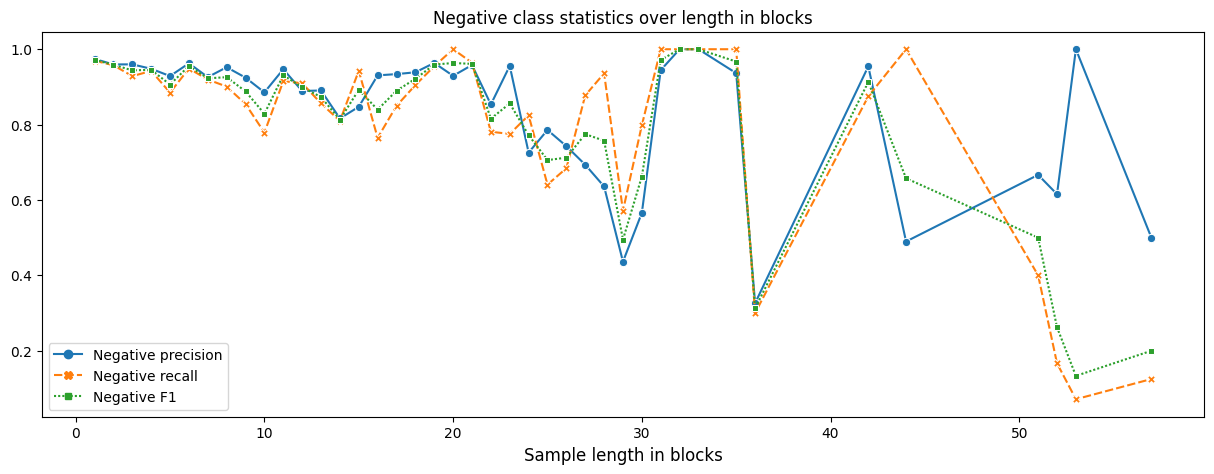

In [35]:
min_support = 10
negative_data = df.loc[df['Negative support'] >= min_support]

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=negative_data[negative_metrics[:-1]], markers=True, ax=ax)
ax.set_xlabel("Sample length in blocks", fontsize=12)
ax.set_title("Negative class statistics over length in blocks")
plt.savefig(os.path.join(length_report_dir, "Negative class statistics"))

Visualize positive statistics

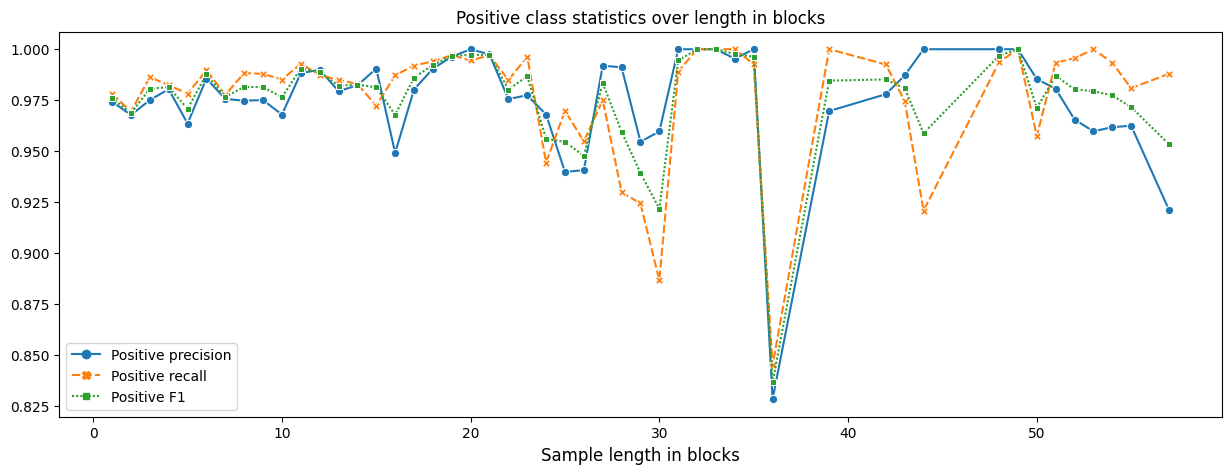

In [36]:
min_support = 10
positive_data = df.loc[df['Positive support'] >= min_support]

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=positive_data[positive_metrics[:-1]], markers=True, ax=ax)
ax.set_xlabel("Sample length in blocks", fontsize=12)
ax.set_title("Positive class statistics over length in blocks")
plt.savefig(os.path.join(length_report_dir, "Positive class statistics"))



Visualize accuracy statistics

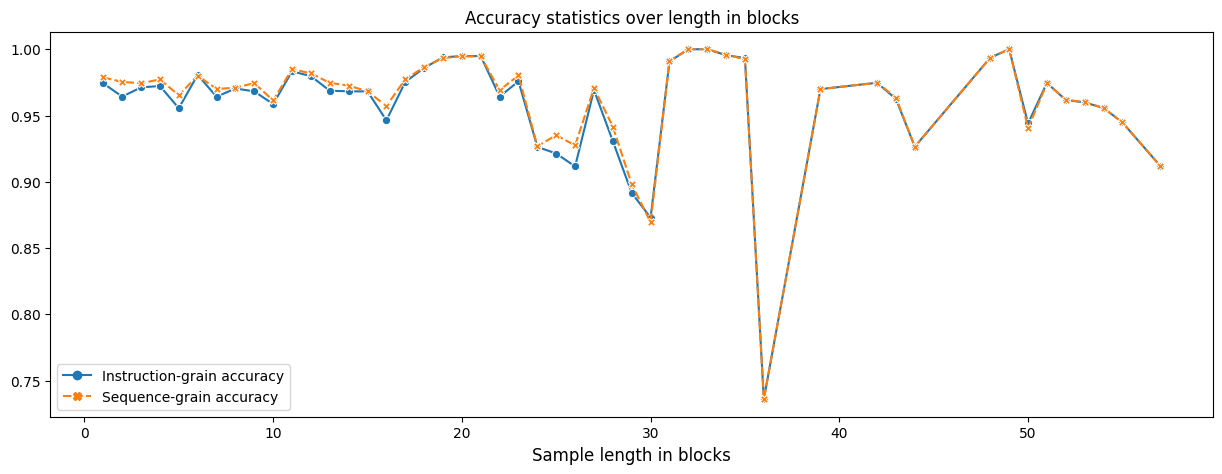

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df[accuracy_metrics[0:2]], markers=True, ax=ax)
ax.set_xlabel("Sample length in blocks", fontsize=12)
ax.set_title("Accuracy statistics over length in blocks")
plt.savefig(os.path.join(length_report_dir, "Accuracy statistics"))